# Binary Classification of Cells Using Neural Network

In [1]:
import sys
import os
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn

print('Python version     :', '{0[0]}.{0[1]}'.format(sys.version_info))
print('Tensorflow version :', tf.__version__)
print('numpy version      :', np.__version__)
np.random.seed(0)
tf.set_random_seed(2)

Python version     : 3.6
Tensorflow version : 1.4.0
numpy version      : 1.13.3


## Dataset

Our dataset consists of total of over 12,000 cells with a total of 2 categories; over 2,000 cells in sequential category  (labelled SQNC) and over 10,000 in combinational category (labelled COMB). 
Each cell in the dataset is represented as a 2D matrix of transistor devices and their parameters given below:


| Device | param1 | param2 | param3 | param4 | param5 | ...... | ...... | param13 |
|--------|--------|--------|--------|--------|--------|--------|--------|---------|
|   10   |    6   |    6   |    3   |    3   |    5   |        |        |    2    |
|   10   |    8   |    3   |    2   |    4   |    4   |    2   |    3   |    6    |
|   20   |    7   |    3   |    2   |    4   |    4   |    2   |    3   |    2    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|   20   |    7   |    3   |    2   |    4   |    5   |    2   |    3   |    2    |


Entire dataset consists of 12,000 such tables labelled as ‘COMB’ or ‘SQNC’ shown in the next picture.


![Cell Dataset As Stack Of Tables](https://github.com/srohit0/mida/blob/master/data/CellDatasetAsStackOfTables.jpg?raw=true)

In [2]:
# max_devices_per_cell is also max number of rows in circuit files in the training set
max_devices_per_cell = 351; 
# feature_per_device is different from max number of cols (14) in circuit files in training set
feature_per_device   = 5; 
feature_indices = (0,2,5,8,11)

def load_one_cell(cell_file):
    cell_cols = 14
    cell_data = np.zeros(shape=(max_devices_per_cell, cell_cols), dtype=np.float32)
    cell_mat  = np.loadtxt(cell_file, dtype=np.float32, ndmin=2)
    nrows     = cell_mat.shape[0]
    ncols     = cell_mat.shape[1]
    cell_data[:nrows, :ncols] = cell_mat
    cell_data = cell_data[:, feature_indices]
    return cell_data

In [3]:
def load_cells(folder):
  #Load the data for a single label.
  cell_files = os.listdir(folder)
  dataset = np.zeros(shape=(len(cell_files), max_devices_per_cell, feature_per_device),
                         dtype=np.float32)
  cell_index = 0
  for cell in cell_files:
    cell_file = os.path.join(folder, cell)
    try:
      cell_data = load_one_cell(cell_file)

      cell_rows = cell_data.shape[0]
      cell_cols = cell_data.shape[1]
      dataset[cell_index, :cell_rows, :cell_cols] = cell_data

      cell_index = cell_index + 1
    except IOError as e:
      print('Could not read:', cell_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:cell_index, :, :]

  print(os.path.basename(folder), ': shape=', dataset.shape, ', Mean=', np.mean(dataset), ', sigma=', np.std(dataset))
  return dataset

comb_dataset = load_cells(os.path.join('..','data','2classes','COMB'))
sqnc_dataset = load_cells(os.path.join('..','data','2classes','SQNC'))

COMB : shape= (10096, 351, 5) , Mean= 0.686939 , sigma= 2.95702
SQNC : shape= (2096, 351, 5) , Mean= 1.36903 , sigma= 4.67975


# Create Labels

In [4]:
# create one hot labels
#         COMB_LABEL=[1.0, 0.0], SQNC_LABEL=[0.0, 1.0]
labels = np.asarray([[1.0, 0.0] if (i<comb_dataset.shape[0]) else [0.0, 1.0] for i in range(comb_dataset.shape[0]+sqnc_dataset.shape[0])])

# Randomize Dataset

In [5]:
# randomize comb and sqnc dataset
np.random.shuffle(comb_dataset)
np.random.shuffle(sqnc_dataset)

# Create a combined dataset
dataset = np.append(comb_dataset, sqnc_dataset, axis=0)

# randomize dataset and labels together to keep'em in sync.
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

# randomize dataset
dataset, labels = randomize(dataset, labels)

print('Full dataset: no. of cells=', dataset.shape, 'Min=', np.min(dataset), 'Max=',np.max(dataset), 
      'Mean=', np.mean(dataset), 'Sigma=', np.std(dataset))

Full dataset: no. of cells= (12192, 351, 5) Min= 0.0 Max= 50.0 Mean= 0.804202 Sigma= 3.32745


# Visualize Dataset
Visualizing your dataset in single dimension gives you clues. Visualizing cells with over 1700 dimensions is a bit overwhelming. So we'll reduce our matrix to a single number including mean, sigma and frobenius norm and see, if there
is a trend.

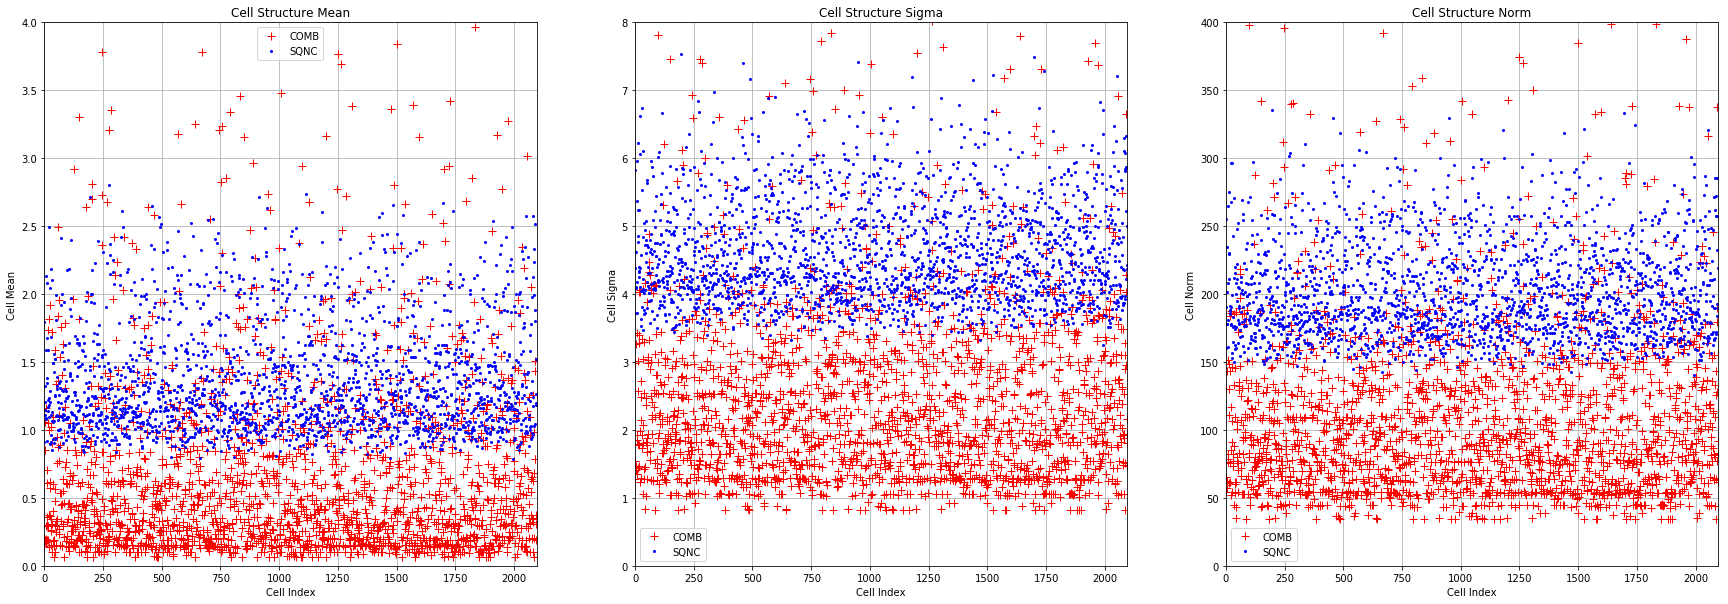

In [6]:
# Frobenius norm of matrices
comb_norms = [np.linalg.norm(cell) for cell in comb_dataset]
sqnc_norms = [np.linalg.norm(cell) for cell in sqnc_dataset]

comb_mean  = [np.mean(cell) for cell in comb_dataset]
sqnc_mean  = [np.mean(cell) for cell in sqnc_dataset]

comb_sigma = [np.std(cell) for cell in comb_dataset]
sqnc_sigma = [np.std(cell) for cell in sqnc_dataset]

comb_size = comb_dataset.shape[0]
sqnc_size = sqnc_dataset.shape[0]

plt.figure(figsize=(30,10))

plt.subplot(1, 3, 1)
plt.grid()
plt.xlim(0,sqnc_size)
plt.ylim(0,4)
plt.plot([i for i in range(comb_size)], comb_mean, 'ro', label='COMB', marker='+', markersize=8)
plt.plot([i for i in range(sqnc_size)], sqnc_mean, 'bo', label='SQNC', marker='.', markersize=4)
plt.title('Cell Structure Mean')
plt.xlabel('Cell Index')
plt.ylabel('Cell Mean')
plt.legend()

plt.subplot(1, 3, 2)
plt.grid()
plt.xlim(0,sqnc_size)
plt.ylim(0,8)
plt.plot([i for i in range(comb_size)], comb_sigma, 'ro', label='COMB', marker='+', markersize=8)
plt.plot([i for i in range(sqnc_size)], sqnc_sigma, 'bx', label='SQNC', marker='.', markersize=4)
plt.title('Cell Structure Sigma')
plt.xlabel('Cell Index')
plt.ylabel('Cell Sigma')
plt.legend()

plt.subplot(1, 3, 3)
plt.grid()
plt.xlim(0,sqnc_size)
plt.ylim(0,400)
plt.plot([i for i in range(comb_size)], comb_norms, 'ro', label='COMB', marker='+', markersize=8)
plt.plot([i for i in range(sqnc_size)], sqnc_norms, 'bo', label='SQNC', marker='.', markersize=4)
plt.title('Cell Structure Norm')
plt.xlabel('Cell Index')
plt.ylabel('Cell Norm')
plt.legend()

plt.show()
plt.close("all")

# Reformat Dataset

In [7]:
def reformat(dataset):
    dataset = dataset.reshape((-1, max_devices_per_cell*feature_per_device))
    return dataset

dataset = reformat(dataset)
print(dataset.shape)

(12192, 1755)


# Normalize Dataset

In [8]:
# normalize the dataset between 0 and 1.
data_mean = 0;
data_std  = (np.max(dataset)-np.min(dataset));

def normalize(d, mean, std):
    return (d - mean) / std

def denormalize(d, mean, std):
    return (d * std) + mean

dataset = normalize(dataset, data_mean, data_std)

print('Min=', np.min(dataset), 'Max=',np.max(dataset), 'Mean=',np.mean(dataset), 'sigma=', np.std(dataset))
print('Dataset size', dataset.shape)
#print('dataset feature min vector = ', np.min(dataset, axis=0))
#print('dataset feature max vector = ', np.max(dataset, axis=0))

Min= 0.0 Max= 1.0 Mean= 0.016084 sigma= 0.066549
Dataset size (12192, 1755)


# Divide dataset
into training dataset and validation dataset

In [9]:
# training dataset percentage is 80%
def divide_dataset(dataset, labels):
    train_pct = 0.8; 
    # divide dataset into training and validation set
    train_index = int(dataset.shape[0]*train_pct)
    t_X = dataset[:train_index, :]
    t_Y = labels[:train_index,:]
    v_X = dataset[train_index:,:]
    v_Y = labels[train_index:,:]
    
    return t_X, t_Y, v_X, v_Y

train_X, train_Y, valid_X, valid_Y = divide_dataset(dataset, labels)

print(train_X.shape)

(9753, 1755)


## Declare Graph Variables

Place to declare plave holders and variables for compute graph

In [10]:
SIGMA      = np.sqrt(2.0/train_X.shape[0])

# Parameters
learning_rate   = 1e-2
l2_loss_beta    = 1e-5
training_epochs = 300
display_step    = 50

# Network Parameters
n_hidden_1 = 100 # 1st layer number of neurons
n_hidden_2 = 10 # 2nd layer number of neurons
n_features = train_X.shape[1]; # num_inputs
n_labels   = 2; # num_classes

# tf Graph input
t_dataset = tf.placeholder(tf.float32, shape=(None, n_features), name='t_dataset');
t_labels  = tf.placeholder(tf.float32, shape=(None, n_labels), name='t_labels');


weights = {
    'h1': tf.Variable(tf.truncated_normal(shape=[n_features, n_hidden_1], mean=3.0*SIGMA, 
                                          stddev=SIGMA, dtype=tf.float32), trainable=True),
    'h2': tf.Variable(tf.truncated_normal(shape=[n_hidden_1, n_hidden_2], mean=3.0*SIGMA, 
                                           stddev=SIGMA, dtype=tf.float32), trainable=True),
    'out': tf.Variable(tf.truncated_normal(shape=[n_hidden_2, n_labels], mean=3.0*SIGMA, 
                                           stddev=SIGMA, dtype=tf.float32), trainable=True)
}
biases = {
    'b1': tf.Variable(tf.constant(value=SIGMA, dtype=tf.float32, shape=[n_hidden_1]), trainable=True),
    'b2': tf.Variable(tf.constant(value=SIGMA, dtype=tf.float32, shape=[n_hidden_2]), trainable=True),
    'out': tf.Variable(tf.constant(value=SIGMA, dtype=tf.float32, shape=[n_labels]), trainable=True)
}

## Compute Graph
Construct a Neural Network model

In [11]:
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [12]:
# Construct model
predictions = neural_net(t_dataset)

t_labels_cls       = tf.argmax(t_labels, axis=1)
predictions_cls    = tf.argmax(predictions, axis=1)
correct_prediction = tf.equal(predictions_cls, t_labels_cls)
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=predictions,
                                                               labels=t_labels_cls)

# L2 loss
regularizers = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['out'])

# Cost
cost = tf.reduce_mean(cross_entropy + l2_loss_beta * regularizers)

# Optimization algorithm
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Train the Model

In [13]:
# Start training
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

t_start = datetime.now()

for epoch in range(training_epochs):

    sess.run(optimizer, feed_dict={t_dataset:train_X, t_labels:train_Y})

    #Display logs per epoch step
    if (epoch+1) % display_step == 0:

        t_cost, t_acc = sess.run([cost, accuracy], feed_dict={t_dataset:train_X, t_labels:train_Y})
        v_cost, v_acc = sess.run([cost, accuracy], feed_dict={t_dataset:valid_X, t_labels:valid_Y})
        print ("[", "{:4d}".format((datetime.now()-t_start).seconds), 
               "sec ] Epoch:", '%04d' % (epoch+1), 
               "cost=", "{:.5f}".format(t_cost),
               "train acc=", "{:.9f}".format(t_acc),
               "valid acc=", "{:.9f}".format(v_acc))

print( "\nOptimization Finished!" )

[   18 sec ] Epoch: 0050 cost= 0.01892 train acc= 0.995283484 valid acc= 0.994669974
[   36 sec ] Epoch: 0100 cost= 0.00880 train acc= 0.999179721 valid acc= 0.996719956
[   54 sec ] Epoch: 0150 cost= 0.00566 train acc= 0.999589860 valid acc= 0.998359978
[   73 sec ] Epoch: 0200 cost= 0.00420 train acc= 0.999897480 valid acc= 0.998769999
[   92 sec ] Epoch: 0250 cost= 0.00343 train acc= 0.999897480 valid acc= 0.998769999
[  109 sec ] Epoch: 0300 cost= 0.00294 train acc= 1.000000000 valid acc= 0.997949958

Optimization Finished!


# Cost and Accuracy

In [14]:
# Find cost on training dataset.
t_cost, t_acc = sess.run([cost, accuracy], feed_dict={t_dataset:train_X, t_labels:train_Y})
v_cost, v_acc = sess.run([cost, accuracy], feed_dict={t_dataset:valid_X, t_labels:valid_Y})

print ("Training   cost    =", t_cost)
print ("Validation cost    =", v_cost, '\n')
print("Training   Accuracy =", t_acc)
print("Validation Accuracy =", v_acc)

#sess.close()

Training   cost    = 0.00293791
Validation cost    = 0.00667793 

Training   Accuracy = 1.0
Validation Accuracy = 0.99795


# The Model

In [15]:
def classifier(X):
    prediction = predictions_cls.eval(session=sess, feed_dict={t_dataset:X, t_labels:[[0, 0]]})
    cell_type = 'COMB' if (prediction == 0 ) else 'SQNC'
    return cell_type

# Test few cells

We'll test few cells here. Uncomment the code below to find all incorrectly classified cells.

In [16]:
sample_cells = [os.path.join('..','data','2classes','COMB', 'AN2_1.mat'), 
                os.path.join('..','data','2classes','SQNC', 'FSDNQO_2.mat'),
                os.path.join('..','data','2classes','COMB', 'AN5_Y2_8_6.mat'),
                os.path.join('..','data','2classes','COMB', 'OAI22_TY2_16.mat'),
                os.path.join('..','data','2classes','COMB', 'MUX5_CTY2_24_1.mat'),
                os.path.join('..','data','2classes','SQNC', 'FSDPQO_6_2.mat'),
                os.path.join('..','data','2classes','COMB', 'MUX3_CTY2_32.mat'),
                os.path.join('..','data','2classes','SQNC', 'FSDNQ_V2_1.mat')]

for cell_file in sample_cells:
    cell_data = normalize(reformat(load_one_cell(cell_file)), data_mean, data_std)
    print (cell_file.ljust(40), 'CLASS is :', classifier(cell_data))


# #Find all incorrectly predicted cells
# print('Cells with incorrect classification: ')
# incorrect_lbls = 0
# for label in ('COMB', 'SQNC'):
#     cell_files = os.listdir(os.path.join('..','data','2classes',label))
#     for cell_file in cell_files:
#         cell_data = normalize(reformat(
#             load_one_cell(
#                 os.path.join('..','data','2classes',label,cell_file)
#             )
#         ), data_mean, data_std)
#         predicted_label = classifier(cell_data)
#         if ( label != predicted_label ):
#             print(cell_file, end=', ')
#             incorrect_lbls += 1
# print ('\nTotal number of incrrection prediction is ', incorrect_lbls)

..\data\2classes\COMB\AN2_1.mat          CLASS is : COMB
..\data\2classes\SQNC\FSDNQO_2.mat       CLASS is : SQNC
..\data\2classes\COMB\AN5_Y2_8_6.mat     CLASS is : SQNC
..\data\2classes\COMB\OAI22_TY2_16.mat   CLASS is : COMB
..\data\2classes\COMB\MUX5_CTY2_24_1.mat CLASS is : COMB
..\data\2classes\SQNC\FSDPQO_6_2.mat     CLASS is : SQNC
..\data\2classes\COMB\MUX3_CTY2_32.mat   CLASS is : COMB
..\data\2classes\SQNC\FSDNQ_V2_1.mat     CLASS is : SQNC


# Confusion Matrix

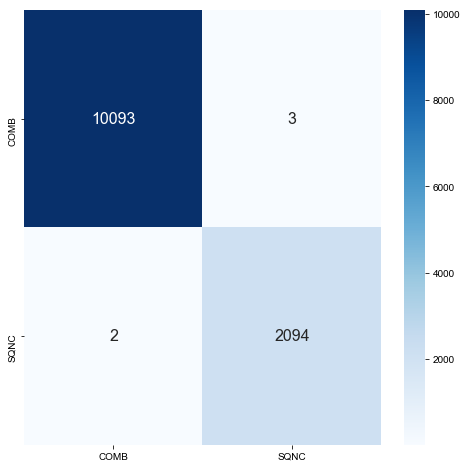

In [17]:
t_predictions = sess.run(predictions, feed_dict={t_dataset:dataset, t_labels:labels})
cm = tf.confusion_matrix(labels=np.argmax(labels, axis=1), predictions=tf.argmax(t_predictions, axis=1), num_classes=2)
cm_ary = cm.eval(session=sess)

plt.figure(figsize = (8,8))
sn.heatmap(cm_ary, xticklabels=['COMB', 'SQNC'], yticklabels=['COMB', 'SQNC'], 
           cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16})# font size
sn.set(font_scale=1.4)#for label size
plt.show()

In [18]:
sess.close()